In [3]:
# menu column at left and images list at right. to be refined..
# plus some styling
from IPython.display import HTML
import urllib2
TOC="https://gist.githubusercontent.com/astyonax/1d7f49edefd9728b7da0/raw"
TOC=urllib2.urlopen(TOC).read()
INAV="https://gist.github.com/astyonax/815eacf44e2efd5eb0a7/raw"
INAV=urllib2.urlopen(INAV).read()
style="https://gist.githubusercontent.com/astyonax/d53a8eb1c556168a65f5/raw"
style=urllib2.urlopen(style).read()
HTML("""
<style>{2}</style>
<style>
    .container{{
        width: 90% !important;
        max-width:90% !important;
    }}
    #img_nav{{
    
        max-width:10% !important;
        padding: 1px !important;
        z-index:10000000000 !important;
    }}
    #thumb_nav{{
        max-width:100%;
    }}
    div.output_area img {{
    max-width:95% !important;
    }}
</style>

<div id="toc"></div>
<script type="text/javascript">
{0}
</script>
<div id="img_nav"></div>
<script type="text/javascript">
{1}
</script>""".format(TOC,INAV,style))

In [1]:
%pylab inline
import numpy as np
import pylab as pl
import scipy
import numexpr as ne
from numba import jit
import sympy

Populating the interactive namespace from numpy and matplotlib


In [2]:

def morlet(eta,w0):
    return ne.evaluate("3.141592653589793**-.25*exp(-.5 * eta**2)*exp(1j*w0*eta)")

def C(s,w0):
    return np.pi**-.25/np.sqrt(2*s)*exp(.25*(w0-sqrt(2+w0**2))**2)

def wlet(y,s,tau,dt,w0):
    
    out=y[0]*morlet((0*dt-tau)/s,w0)
    for i in xrange(1,y.shape[0]): # this is slow but, now, I do not know how to go faster
        out+=y[i]*morlet((i*dt-tau)/s,w0)
    return dt/np.sqrt(s)*out
    

def wlet_2(y,s,tau,dt,w0):
    
    ## THIS IS SUPER MEMORY HUNGRY!!!!
    NT=np.arange(y.shape[0])
    out=morlet((dt*NT[:,np.newaxis,np.newaxis]-tau)/s,w0)
    
    out=(y[:,np.newaxis,np.newaxis]*out).sum(axis=0)
    return dt/np.sqrt(s)*out



f2s=lambda f,w0:(w0+sqrt(2+w0**2))/(4*np.pi*f)
s2f=lambda s,w0:(w0+sqrt(2+w0**2))/(4*np.pi*s)

def wlet_trans(data,fmin,fmax,df,dt_sample,dt,w0=50):
    """
    This function performs the 1D wavelet transform of 'data'
    using the morlet wavelet.
    The code is based on the paper: http://dx.doi.org/10.1098/rsif.2014.0672
    
    Input:
    -data is a 1D numpy.ndarray
    -fmin,  fmax, and df define the frequency range spanned by the transform 
     as in np.arange(fmin,fmax+df,df)
    -dt_sample is the sampling rate of the input signal
    -dt is the transform time stepping
    -w0 -- see ref.. determines time vs spatial resolution
    
    Output:
    -spectrogram
    -times
    -frequencies
    """
    smax=f2s(fmin,w0)
    smin=f2s(fmax,w0)
    
    taus=np.arange(0,data.shape[0]*dt_sample,dt)
    ff=np.arange(fmin,fmax+df,df)
    ss=f2s(ff,w0)
    
    tauss,ss=np.meshgrid(taus,ss)
    X,Y=tauss.shape
    print "transform size:",X*Y,"bins"
    WL=wlet
    if X*Y<41000:
        WL=wlet_2
    transformed_data=wlet(data,s=ss,tau=tauss,dt=dt_sample,w0=w0)/C(ss,w0=w0)[::-1]
    #return C(ss,w0=w0),taus,ff
    print transformed_data.shape
    return transformed_data,taus,ff
    

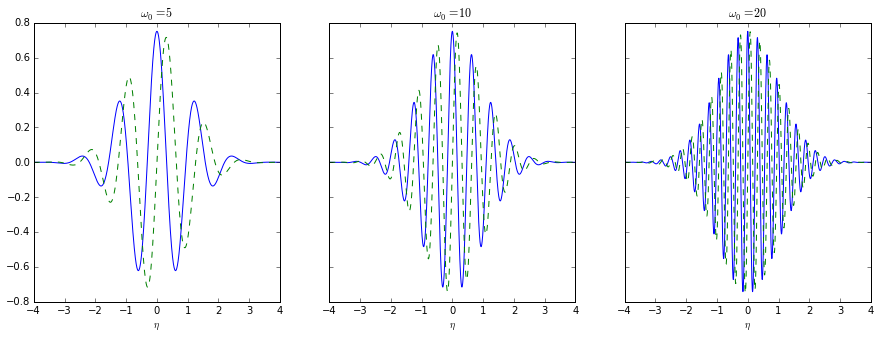

In [17]:
etas=np.arange(-4,4,.001)
w0s=[5,10,20]
N=len(w0s)
f,ax=pl.subplots(1,N,figsize=(N*5,5),sharex='all',sharey='all')
for w0,ax in zip(w0s,ax):
    ax.plot(etas,morlet(etas,w0).real,lw=1)
    ax.plot(etas,morlet(etas,w0).imag,'--',lw=1)
    ax.set_title(r"$\omega_0={:d}$".format(w0))
    ax.set_xlabel(r"$\eta$")

# The theory under test

transform size: 40250 bins
(46, 875)
transform size: 40250 bins
(46, 875)
transform size: 40250 bins
(46, 875)


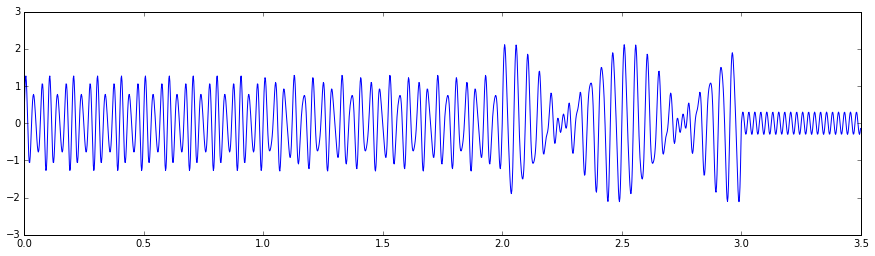

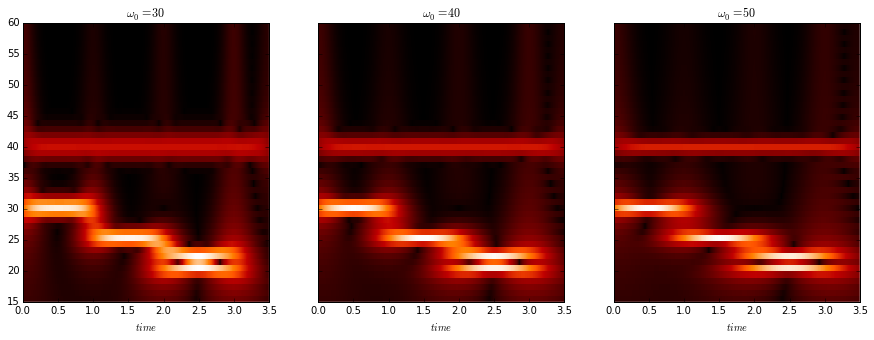

In [18]:
# Test with synthetic signal
dt=1/500. # 500Hz
t=np.arange(0,3.5,dt)
data=np.sin(2*np.pi*30*t)*(t<1)
data+=np.sin(2*np.pi*25*t)*((t>1)&(t<2))
data+=np.sin(2*np.pi*t*20)*((t>2) & (t<3))
data+=np.sin(2*np.pi*t*22)*((t>2) & (t<3))
data+=np.sin(2*np.pi*t*40)*.3
pl.figure(figsize=(15,4))
pl.plot(t,data)

w0s=[30,40,50]
N=len(w0s)
f,ax=pl.subplots(1,N,figsize=(N*5,5),sharex='all',sharey='all')
for w0,ax in zip(w0s,ax):
    tdata,taus,ff=wlet_trans(data,15,60,1,dt,dt*2,w0)
    extend=[0,taus.max(),ff.min(),ff.max()]
    ax.imshow(np.abs(tdata)**.5,aspect="auto",cmap=pl.cm.gist_heat,extent=extend,interpolation="none",origin="bottom")
    ax.set_title(r"$\omega_0={:d}$".format(w0))
    ax.set_xlabel(r"$time$")

In [61]:
T=np.arange(0,800)
S=np.arange(1,30)
TT,SS=np.meshgrid(T,S)
print morlet((TT[:,np.newaxis]*dt-TT)/SS,10.).shape


(29, 29, 800)


# Some theory with sympy

In [2]:
import sympy
sympy.init_printing()

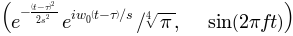

In [3]:
s,t,tau,f,w0,eta,y,psi=sympy.symbols("s t tau f w0 eta y psi",positive=1,real=1)

psi=(sympy.pi**(-sympy.Rational(1,4))*sympy.exp(-sympy.Rational(1,2) *eta**2)*sympy.exp(sympy.I*w0*eta))
psi=psi.subs(eta,(t-tau)/s)
y=sympy.sin(2*sympy.pi*f*t)
psi,y

In [4]:
WL=sympy.integrate(psi*y,(t,-sympy.oo,sympy.oo))

KeyboardInterrupt: 

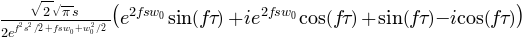

In [11]:
result=sympy.simplify(WL)
result

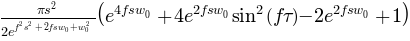

In [16]:
sympy.simplify(result*result.conjugate())